In [1]:
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from tqdm import tqdm

In [2]:
import time
start_time = time.time()

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

## **String preprocessing function**

In [3]:
def clean_string_name(string):
    text = string.replace(' Size: 4 oz. * USDA Certified Organic Ingredient ** None remains after saponifying oils into soap and glycerin', '')
    pattern = "[\|\*\_\'\{}&]".format('"')
    regex1 = re.compile('\[.*]')
    regex2 = re.compile('\[.*}')
    text = re.sub(pattern, "", text)
    text = re.sub(regex1, "", text)
    text = re.sub(regex2, "", text)
    text = text.strip('\x0c')
    text = text.strip(' ')
    text = text.upper()
    text = text.replace('INACTIVE INGREDIENTS:', '')
    text = text.replace('ACTIVE INGREDIENTS:', '')

    return text

In [81]:
mismatch = ['CAVIAR WATER', 'STEM WATER']
def convert_new_ing_list(x):
    trimed = [name.strip(" '").strip("''") for name in x.strip('[]').split(',')]
    res = ''

    for i in range(len(trimed)):
        if i != (len(trimed) -1):
            if trimed[i] in mismatch:
                res = res + 'WATER' + ', '
            else:
                res = res + trimed[i] + ', '
        else: 
            if trimed[i] in mismatch:
                res = res + 'WATER' + ', '
            else:
                res = res + trimed[i]
    return res

## **Load dataset**

In [82]:
df_skin = pd.read_csv('../Database/EWG/ewg_skin_products_transformed_8208.csv')
df_sun = pd.read_csv('../Database/EWG/ewg_sun_products_transformed_1565.csv')
df_makeup = pd.read_csv('../Database/EWG/ewg_makeup_products_transformed_10527.csv')

df_hair = pd.read_csv('../Database/EWG/ewg_hair_products_transformed_4908.csv')
df_or = pd.read_csv('../Database/EWG/ewg_oralcare_products_transformed_937.csv')
df_frag = pd.read_csv('../Database/EWG/ewg_fragrance_products_transformed_484.csv')

In [83]:
df_all = pd.concat([df_skin, df_sun, df_makeup, df_hair, df_or, df_frag])

### **Cleaning df_all**

In [84]:
df_all.shape

(26625, 9)

In [85]:
df_all.duplicated().sum()

3365

In [86]:
df_all.drop_duplicates(inplace=True)
df_all['new_ing_list_fixed'] = df_all['new_ing_list'].apply(convert_new_ing_list)
df_all['new_product_score'] = df_all['product_score'].map({'verified': 1,
                                                          '01': 2,
                                                          '02': 3,
                                                          '03': 4,
                                                          '04': 5,
                                                          '05': 6,
                                                          '06': 7,
                                                          '07': 8,
                                                          '08': 9,
                                                          '09': 10,
                                                          '10': 10,})
df_all.reset_index(drop=True, inplace=True)

In [87]:
drop_index = df_all[df_all['new_ing_list'] == '[]'].index.to_list()
df_all.drop(drop_index, inplace=True)
df_all.reset_index(drop=True, inplace=True)

In [88]:
df_all = df_all.sample(frac=1)
df_all.reset_index(drop=True, inplace=True)

In [89]:
df_all['new_product_score'].value_counts()

4     4459
5     4364
3     4266
6     3444
2     2358
1     1773
7     1512
8      526
9      199
10      92
Name: new_product_score, dtype: int64

### **Word count**

In [90]:
vocab = Counter()

for ing in df_all['new_ing_list_fixed']:
    for words in ing.split(', '):
        vocab[words] += 1

In [91]:
most_vocab = vocab.most_common(1000)
common_vocab = pd.DataFrame(most_vocab, columns=['word', 'frequency'])

In [92]:
ingredient_idx_1000 = {ing[0]: idx for idx, ing in enumerate(most_vocab)}

In [93]:
ingredient_idx_1000

{'WATER': 0,
 'PHENOXYETHANOL': 1,
 'GLYCERIN': 2,
 'IRON OXIDES': 3,
 'TITANIUM DIOXIDE': 4,
 'SILICA': 5,
 'TOCOPHERYL ACETATE': 6,
 'TOCOPHEROL': 7,
 'DIMETHICONE': 8,
 'CITRIC ACID': 9,
 'MICA': 10,
 'CI 77492': 11,
 'CAPRYLYL GLYCOL': 12,
 'CAPRIC TRIGLYCERIDE': 13,
 'CI 77499': 14,
 'ETHYLHEXYLGLYCERIN': 15,
 'GRANITE': 16,
 'SODIUM CHLORIDE': 17,
 'XANTHAN GUM': 18,
 'BUTYROSPERMUM PARKII BUTTER': 19,
 'BUTYLENE GLYCOL': 20,
 'POTASSIUM SORBATE': 21,
 'DISODIUM EDTA': 22,
 'CYCLOPENTASILOXANE': 23,
 'ALOE BARBADENSIS LEAF JUICE': 24,
 'DISTEARDIMONIUM HECTORITE': 25,
 'LIMONENE': 26,
 'COCOS NUCIFERA OIL': 27,
 'SIMMONDSIA CHINENSIS SEED OIL': 28,
 'HELIANTHUS ANNUUS SEED OIL': 29,
 'SODIUM BENZOATE': 30,
 'ISODODECANE': 31,
 'CETEARYL ALCOHOL': 32,
 'LINALOOL': 33,
 'SODIUM HYALURONATE': 34,
 'CETYL ALCOHOL': 35,
 'POLYETHYLENE': 36,
 'PANTHENOL': 37,
 'TRIMETHYLSILOXYSILICATE': 38,
 'TALC': 39,
 'TIN OXIDE': 40,
 'BENZYL ALCOHOL': 41,
 'STEARIC ACID': 42,
 'PROPYLENE CARBONATE

In [59]:
import pickle

# a = {'hello': 'world'}

with open('ingredient_idx_1000.pickle', 'wb') as handle:
    pickle.dump(ingredient_idx_1000, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('ingredient_idx_1000.pickle', 'rb') as handle:
    ingredient_1000 = pickle.load(handle)


In [60]:
len(ingredient_1000)

1000

### **Tokenize**

In [94]:
corpus = []
for i in tqdm(range(len(df_all))):
    ingredients = df_all['new_ing_list_fixed'][i]
#     print(ingredients)
    tokens = ingredients.split(', ')    
    corpus.append(tokens)

100%|██████████| 22993/22993 [00:00<00:00, 24160.15it/s]


In [96]:
len(corpus)

22993

In [97]:
# Define the oh_encoder function
def oh_encoder(tokens):
    x = np.zeros(N)    
    for ingredient in tokens:
        if ingredient in ingredient_idx.keys():
            idx = ingredient_idx[ingredient]
            x[idx] = 1
        else:
            pass
    return x

In [101]:
len(ingredient_idx)

7433

In [116]:
# Get the number of items and tokens 
M = len(df_all)                 # The number of the items
N = len(ingredient_idx)     # The number of the ingredients

# Initialize a matrix of zeros
A = np.zeros((M, N), dtype=np.uint8)

In [117]:
# Make a document-term matrix
i = 0
for tokens in corpus:
    A[i, :] = oh_encoder(tokens)
    i += 1

In [118]:
# columns name
ingredient_idx_key = [key for key in ingredient_idx.keys()]
df_sorted = pd.DataFrame(A, columns = ingredient_idx_key) 

# append to the original df
df_vector = pd.concat([df_all, df_sorted], axis=1)

In [108]:
df_vector

,cat_name,subcat_name,product_url,product_brand,product_name,product_score,product_img,ingredient_list,new_ing_list,new_ing_list_fixed,...,ALPINIA FORMOSANA SEED POWDER,SARGASSUM FUSIFORME EXTRACT,ISOSTEARAMIDOMORPHOLINE STEARATE,GLUTAMIC ACID FERMENT FILTRATE,APRICOT KERNEL AMINO ACIDS,OROTIC ACID,ACTINIDIA CHINENSIS FRUIT JUICE,CORN ACID,PEANUT ACID,TARAXACUM OFFICINALE
0,Skin,Facial Cleanser,https://www.ewg.org/skindeep/products/867632-G...,Garnier,SkinActive All-in-1 Rinse Off Micellar Foaming...,02,https://static.ewg.org/skindeep_images/8676/86...,"967118 2 WATER, GLYCERIN, PEG-200 HYDROGENATED...","['GLYCERIN', 'PEG-200 HYDROGENATED GLYCERYL PA...","GLYCERIN, PEG-200 HYDROGENATED GLYCERYL PALMAT...",...,0,0,0,0,0,0,0,0,0,0
1,Makeup,Lipstick,https://www.ewg.org/skindeep/products/883232-D...,Doucce,"Lovestruck Matte Liquid Lipstick, 507 Gelato",05,https://static.ewg.org/skindeep_images/8832/88...,"ISODODECANE, TRIMETHYLSILOXYSILICATE, ISOSTEAR...","['ISODODECANE', 'TRIMETHYLSILOXYSILICATE', 'IS...","ISODODECANE, TRIMETHYLSILOXYSILICATE, ISOSTEAR...",...,0,0,0,0,0,0,0,0,0,0
2,Skin,Body Firming Lotion,https://www.ewg.org/skindeep/products/846813-S...,Shea Moisture,Superfruit Multi Vitamin Firming Body Lotion,04,https://static.ewg.org/skindeep_images/8468/84...,"WATER, CAPRIC/CAPRYLIC TRIGLYCERIDES, GLYCERYL...","['WATER', 'CAPRIC TRIGLYCERIDE', 'GLYCERYL STE...","WATER, CAPRIC TRIGLYCERIDE, GLYCERYL STEARATE,...",...,0,0,0,0,0,0,0,0,0,0
3,Makeup,Lipstick,https://www.ewg.org/skindeep/products/817365-T...,tarte,"ist Lip Paint, (Choker, Brownie)",03,https://static.ewg.org/skindeep_images/8173/81...,"Dimethicone, polymethylsilsesquioxane, mica, c...","['DIMETHICONE', 'POLYMETHYLSILSESQUIOXANE', 'M...","DIMETHICONE, POLYMETHYLSILSESQUIOXANE, MICA, C...",...,0,0,0,0,0,0,0,0,0,0
4,Makeup,Lip Gloss,https://www.ewg.org/skindeep/products/840471-O...,OFRA,"Cosmetics Lip Gloss, Bordeaux",03,https://static.ewg.org/skindeep_images/8404/84...,"Hydrogenated Polyisobutene, Dipentaerythrityl ...","['HYDROGENATED POLYISOBUTENE', 'DIPENTAERYTHRI...","HYDROGENATED POLYISOBUTENE, DIPENTAERYTHRITYL ...",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22988,Hair,Conditioner,https://www.ewg.org/skindeep/products/877189-A...,Alaffia,"Everyday Coconut Ultra Hydrating Conditioner, ...",04,https://static.ewg.org/skindeep_images/8771/87...,"ZINGIBER OCINALE (GINGER) AQUEOUS EXTRACT, COC...","['ZINGIBER OFFICINALE ROOT EXTRACT', 'COCOS NU...","ZINGIBER OFFICINALE ROOT EXTRACT, COCOS NUCIFE...",...,0,0,0,0,0,0,0,0,0,0
22989,Skin,Hand Cream,https://www.ewg.org/skindeep/products/841808-J...,Jack Black,Industrial Strength Hand Healer,04,https://static.ewg.org/skindeep_images/8418/84...,"WATER (AQUA), CETEARYL ALCOHOL, GLYCERIN, COCO...","['WATER', 'CETEARYL ALCOHOL', 'GLYCERIN', 'COC...","WATER, CETEARYL ALCOHOL, GLYCERIN, COCOGLYCERI...",...,0,0,0,0,0,0,0,0,0,0
22990,Skin,Body Wash/Cleanser,https://www.ewg.org/skindeep/products/794048-K...,Kosmatology,"Botanical Bliss Body Wash, Lavender Eucalyptus",01,https://static.ewg.org/skindeep_images/7940/79...,"Aqua, Organic Olea europaea (Olive) oil, Potas...","['WATER', 'OLEA EUROPAEA LEAF OIL', 'POTASSIUM...","WATER, OLEA EUROPAEA LEAF OIL, POTASSIUM HYDRO...",...,0,0,0,0,0,0,0,0,0,0
22991,Makeup,Lip Gloss,https://www.ewg.org/skindeep/products/927205-B...,Bitzy,"Long Lasting Lip Gloss, Comfort Level",04,https://static.ewg.org/skindeep_images/9272/92...,"ETHYLHEXYL PALMITATE , CAPRYLIC/CAPRIC TRIGLYC...","['ETHYLHEXYL PALMITATE', 'CAPRIC TRIGLYCERIDE'...","ETHYLHEXYL PALMITATE, CAPRIC TRIGLYCERIDE, HYD...",...,0,0,0,0,0,0,0,0,0,0


In [109]:
df_vector.to_csv('ewg_all_products_vector.csv', index=False)

In [110]:
df = pd.read_csv('ewg_all_products_vector.csv')

# **PCA**

In [167]:
from sklearn.decomposition import PCA

In [168]:
df_dataset_cut = df_dataset.iloc[:, 10:]
df_dataset_cut

,new_product_score,WATER,PHENOXYETHANOL,GLYCERIN,IRON OXIDES,TITANIUM DIOXIDE,SILICA,TOCOPHERYL ACETATE,TOCOPHEROL,DIMETHICONE,...,OAT AMINO ACIDS,ACACIA FARNESIANA GUM,CYNANCHUM ATRATUM WATER,LINALOOL OXIDE,CYCLOHEXANE,C15 ALCOHOL,DILAURYL THIODIPROPIONATE,HC ORANGE NO. 1,HC VIOLET NO. 1,METHYLCINNAMYL ALCOHOL
0,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23255,3,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23256,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23257,6,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23258,4,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [169]:
y = df_dataset_cut['new_product_score'].to_numpy()
X = df_dataset_cut.iloc[:, 1:].to_numpy(dtype = np.uint8)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

In [174]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (18608, 7433)
y_train shape:  (18608,)
X_test shape:  (4652, 7433)
y_test shape:  (4652,)


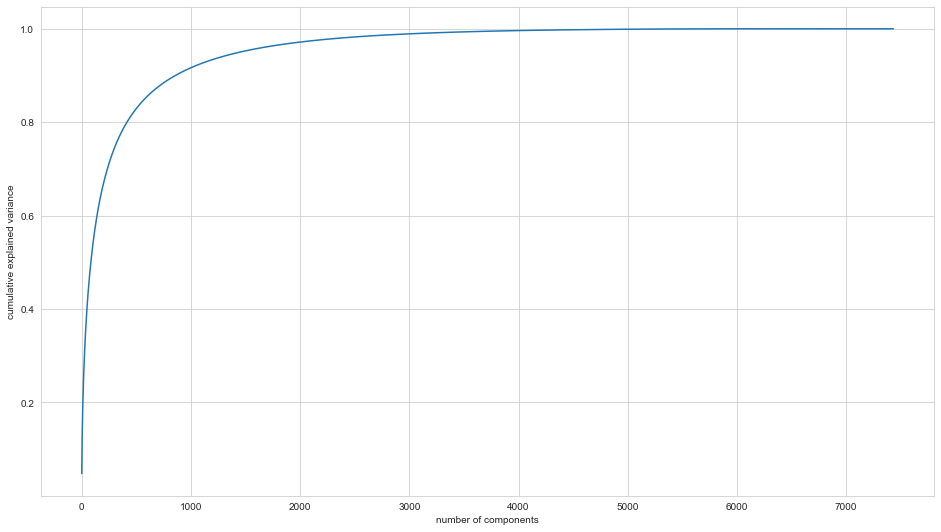

In [175]:
sns.set_style('whitegrid')

pca = PCA().fit(X_train)

plt.figure(figsize=(16, 9))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# **Customize transformer**

In [360]:
df_dataset[['new_ing_list_fixed', 'new_product_score']]

,new_ing_list_fixed,new_product_score
0,"WATER, SULFATED COCONUT OIL, ISOMERIZED PALM O...",2
1,"ALCOHOL DENAT., APAFLURANE, OCTYLACRYLAMIDE CO...",6
2,"CALCIUM CARBONATE, GLYCERIN, WATER, XYLITOL, H...",3
3,"TITANIUM DIOXIDE, ETHYLHEXYL PALMITATE, CYCLOM...",4
4,"SULFATED COCONUT OIL, OLIVE OIL, ALMOND OIL, S...",3
...,...,...
23255,"BUTANE, HYDROFLUOROCARBON 152A, ETHYL TRISILOX...",3
23256,"CARNAUBA ACID WAX, OZONIZED CASTOR OIL, HYDROG...",2
23257,"WATER, DIPROPYLENE GLYCOL, GLYCERIN, NIACINAMI...",6
23258,"ISODODECANE, TRIMETHYLOLPROPANE TRIISOSTEARATE...",4


In [386]:
drop_index = df_dataset[df_dataset['new_ing_list_fixed'].isna()].index.to_list()
df_dataset.drop(drop_index, inplace=True)

AttributeError: 'NoneType' object has no attribute 'reset_index'

In [388]:
# df_dataset.reset_index(drop=True, inplace=True)

In [338]:
sample = [['WATER', 'PHENOXYETHANOL', 'GLYCERIN', 'IRON OXIDES', 'TITANIUM DIOXIDE'],
         ['TOCOPHERYL ACETATE', 'DIMETHICONE', 'TOCOPHEROL', 'CITRIC ACID']]
met = IngredientTokenizer()
a = met.transform(sample)

In [72]:
from sklearn.base import BaseEstimator, TransformerMixin

class IngredientTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X): # X: nested list
        M = len(X)
        N = 1000
        A = np.zeros((M, N), dtype=np.uint8)
        i= 0
        for ing_list in X:
            x = np.zeros(N, dtype=np.uint8)
            for ingredient in ing_list:
                # Get the index for each ingredient
                if ingredient in ingredient_idx_1000.keys():
                    idx = ingredient_idx_1000[ingredient]
                    x[idx] = 1
                else:
                    pass
            
            A[i, :] = x
            i += 1
        return A

In [343]:
with open('ingredient_idx_1000.pickle', 'rb') as handle:
    ingredient_idx = pickle.load(handle)

In [144]:
def column_to_list(df, col_name):
    corpus = []
    for i in tqdm(range(len(df))):
        
        ingredients = df[col_name][i]
        if not isinstance(ingredients, str):
            print(ingredients)
            ingredients = str(ingredients)
        tokens = ingredients.split(', ')    
        corpus.append(tokens)
    return corpus

In [64]:
X = column_to_list(df_all, 'new_ing_list_fixed')
y = df_all['new_product_score'].to_numpy()

100%|██████████| 22993/22993 [00:00<00:00, 27439.81it/s]


# **Random Forest**

In [119]:
df_vector

,cat_name,subcat_name,product_url,product_brand,product_name,product_score,product_img,ingredient_list,new_ing_list,new_ing_list_fixed,...,ALPINIA FORMOSANA SEED POWDER,SARGASSUM FUSIFORME EXTRACT,ISOSTEARAMIDOMORPHOLINE STEARATE,GLUTAMIC ACID FERMENT FILTRATE,APRICOT KERNEL AMINO ACIDS,OROTIC ACID,ACTINIDIA CHINENSIS FRUIT JUICE,CORN ACID,PEANUT ACID,TARAXACUM OFFICINALE
0,Skin,Facial Cleanser,https://www.ewg.org/skindeep/products/867632-G...,Garnier,SkinActive All-in-1 Rinse Off Micellar Foaming...,02,https://static.ewg.org/skindeep_images/8676/86...,"967118 2 WATER, GLYCERIN, PEG-200 HYDROGENATED...","['GLYCERIN', 'PEG-200 HYDROGENATED GLYCERYL PA...","GLYCERIN, PEG-200 HYDROGENATED GLYCERYL PALMAT...",...,0,0,0,0,0,0,0,0,0,0
1,Makeup,Lipstick,https://www.ewg.org/skindeep/products/883232-D...,Doucce,"Lovestruck Matte Liquid Lipstick, 507 Gelato",05,https://static.ewg.org/skindeep_images/8832/88...,"ISODODECANE, TRIMETHYLSILOXYSILICATE, ISOSTEAR...","['ISODODECANE', 'TRIMETHYLSILOXYSILICATE', 'IS...","ISODODECANE, TRIMETHYLSILOXYSILICATE, ISOSTEAR...",...,0,0,0,0,0,0,0,0,0,0
2,Skin,Body Firming Lotion,https://www.ewg.org/skindeep/products/846813-S...,Shea Moisture,Superfruit Multi Vitamin Firming Body Lotion,04,https://static.ewg.org/skindeep_images/8468/84...,"WATER, CAPRIC/CAPRYLIC TRIGLYCERIDES, GLYCERYL...","['WATER', 'CAPRIC TRIGLYCERIDE', 'GLYCERYL STE...","WATER, CAPRIC TRIGLYCERIDE, GLYCERYL STEARATE,...",...,0,0,0,0,0,0,0,0,0,0
3,Makeup,Lipstick,https://www.ewg.org/skindeep/products/817365-T...,tarte,"ist Lip Paint, (Choker, Brownie)",03,https://static.ewg.org/skindeep_images/8173/81...,"Dimethicone, polymethylsilsesquioxane, mica, c...","['DIMETHICONE', 'POLYMETHYLSILSESQUIOXANE', 'M...","DIMETHICONE, POLYMETHYLSILSESQUIOXANE, MICA, C...",...,0,0,0,0,0,0,0,0,0,0
4,Makeup,Lip Gloss,https://www.ewg.org/skindeep/products/840471-O...,OFRA,"Cosmetics Lip Gloss, Bordeaux",03,https://static.ewg.org/skindeep_images/8404/84...,"Hydrogenated Polyisobutene, Dipentaerythrityl ...","['HYDROGENATED POLYISOBUTENE', 'DIPENTAERYTHRI...","HYDROGENATED POLYISOBUTENE, DIPENTAERYTHRITYL ...",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22988,Hair,Conditioner,https://www.ewg.org/skindeep/products/877189-A...,Alaffia,"Everyday Coconut Ultra Hydrating Conditioner, ...",04,https://static.ewg.org/skindeep_images/8771/87...,"ZINGIBER OCINALE (GINGER) AQUEOUS EXTRACT, COC...","['ZINGIBER OFFICINALE ROOT EXTRACT', 'COCOS NU...","ZINGIBER OFFICINALE ROOT EXTRACT, COCOS NUCIFE...",...,0,0,0,0,0,0,0,0,0,0
22989,Skin,Hand Cream,https://www.ewg.org/skindeep/products/841808-J...,Jack Black,Industrial Strength Hand Healer,04,https://static.ewg.org/skindeep_images/8418/84...,"WATER (AQUA), CETEARYL ALCOHOL, GLYCERIN, COCO...","['WATER', 'CETEARYL ALCOHOL', 'GLYCERIN', 'COC...","WATER, CETEARYL ALCOHOL, GLYCERIN, COCOGLYCERI...",...,0,0,0,0,0,0,0,0,0,0
22990,Skin,Body Wash/Cleanser,https://www.ewg.org/skindeep/products/794048-K...,Kosmatology,"Botanical Bliss Body Wash, Lavender Eucalyptus",01,https://static.ewg.org/skindeep_images/7940/79...,"Aqua, Organic Olea europaea (Olive) oil, Potas...","['WATER', 'OLEA EUROPAEA LEAF OIL', 'POTASSIUM...","WATER, OLEA EUROPAEA LEAF OIL, POTASSIUM HYDRO...",...,0,0,0,0,0,0,0,0,0,0
22991,Makeup,Lip Gloss,https://www.ewg.org/skindeep/products/927205-B...,Bitzy,"Long Lasting Lip Gloss, Comfort Level",04,https://static.ewg.org/skindeep_images/9272/92...,"ETHYLHEXYL PALMITATE , CAPRYLIC/CAPRIC TRIGLYC...","['ETHYLHEXYL PALMITATE', 'CAPRIC TRIGLYCERIDE'...","ETHYLHEXYL PALMITATE, CAPRIC TRIGLYCERIDE, HYD...",...,0,0,0,0,0,0,0,0,0,0


In [123]:
df_vector.iloc[:, 11:1011]

,WATER,PHENOXYETHANOL,GLYCERIN,IRON OXIDES,TITANIUM DIOXIDE,SILICA,TOCOPHERYL ACETATE,TOCOPHEROL,DIMETHICONE,CITRIC ACID,...,BRONZITE POWDER,CALENDULA OFFICINALIS FLOWER WATER,OLEYL ALCOHOL,HYDROLYZED OAT PROTEIN,SORBITAN PALMITATE,LITHIUM MAGNESIUM SILICATE,PHYTANTRIOL,HYDROGENATED PALM GLYCERIDES,HYDROLYZED SODIUM HYALURONATE,BETA-CAROTENE
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22988,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22989,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
22990,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22991,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [151]:
y = df_vector['new_product_score'].to_numpy()
X = df_vector.iloc[:, 11:1011].to_numpy()

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

In [152]:
print('X_train shape: ', X.shape)
print('y_train shape: ', y.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (22993, 1000)
y_train shape:  (22993,)
X_test shape:  (4599, 1000)
y_test shape:  (4599,)


In [142]:
from sklearn.svm import SVC
svc = SVC(C=10, kernel='rbf')

In [70]:
# model_pipeline = Pipeline([
#         ('tokenizer', IngredientTokenizer()),
#         ('scv', RandomForestClassifier(n_estimators=250, criterion='gini', max_depth=250)),
#     ])
# model_scv_pipeline = Pipeline([
#         ('tokenizer', IngredientTokenizer()),
#         ('scv', svc),
#     ])

In [430]:
# model_scv_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tokenizer', IngredientTokenizer()), ('scv', SVC(C=10))])

In [153]:
forest_clf = RandomForestClassifier(n_estimators=250, criterion='gini', max_depth=200)
forest_clf.fit(X, y)

RandomForestClassifier(max_depth=200, n_estimators=250)

### **Predict**

In [145]:
# Predict on training set
train_predict = svc.predict(X_train)
print('Accuracy:', accuracy_score(y_train, train_predict))

Accuracy: 0.9642818310318582


In [146]:
# Predict on test set
test_predict = svc.predict(X_test)
print('Accuracy:', accuracy_score(y_test, test_predict))

Accuracy: 0.7408132202652751


### **Confusion matrix**

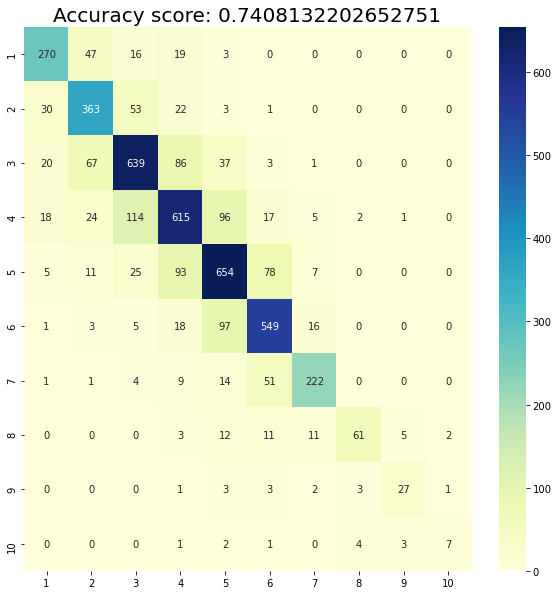

In [148]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(y_test, test_predict), cmap="YlGnBu", annot=True, fmt="d",
           xticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
           yticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.title(f'Accuracy score: {accuracy_score(y_test, test_predict)}', fontsize=20)
plt.show()

# **GridSearch**

18394

In [73]:
parameters = {'scv__kernel': ['poly', 'rbf'],
              'scv__C':[1, 10, 100]}

model_scv_pipeline = Pipeline([
        ('tokenizer', IngredientTokenizer()),
        ('scv', svc),
    ])

gridsearch_svc_models = GridSearchCV(estimator=model_scv_pipeline,
                                 param_grid=parameters,
                                 scoring='accuracy',
                                 n_jobs=-1)

gridsearch_svc_models.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tokenizer', IngredientTokenizer()),
                                       ('scv', SVC(C=10))]),
             n_jobs=-1,
             param_grid={'scv__C': [1, 10, 100],
                         'scv__kernel': ['poly', 'rbf']},
             scoring='accuracy')

In [463]:
model_scv_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tokenizer', 'scv', 'scv__C', 'scv__break_ties', 'scv__cache_size', 'scv__class_weight', 'scv__coef0', 'scv__decision_function_shape', 'scv__degree', 'scv__gamma', 'scv__kernel', 'scv__max_iter', 'scv__probability', 'scv__random_state', 'scv__shrinking', 'scv__tol', 'scv__verbose'])

In [74]:
pd.DataFrame(gridsearch_svc_models.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scv__C,param_scv__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,659.419240,11.690681,94.407260,1.514674,1,poly,"{'scv__C': 1, 'scv__kernel': 'poly'}",0.626801,0.622995,0.628160,0.634140,0.628874,0.628194,0.003600,6
1,493.740338,30.079700,94.481050,5.911921,1,rbf,"{'scv__C': 1, 'scv__kernel': 'rbf'}",0.688502,0.686328,0.687415,0.694210,0.700924,0.691476,0.005451,4
2,561.896570,16.465161,75.146357,2.297088,10,poly,"{'scv__C': 10, 'scv__kernel': 'poly'}",0.682522,0.686600,0.688230,0.690949,0.696846,0.689029,0.004768,5
3,419.899144,4.577887,73.803266,0.478312,10,rbf,"{'scv__C': 10, 'scv__kernel': 'rbf'}",0.724653,0.728187,0.713237,0.729002,0.733551,0.725726,0.006858,1
4,570.825426,99.572568,109.818062,15.625459,100,poly,"{'scv__C': 100, 'scv__kernel': 'poly'}",0.705898,0.705898,0.706714,0.712150,0.709897,0.708111,0.002500,3
5,513.979559,128.320364,77.373884,15.217065,100,rbf,"{'scv__C': 100, 'scv__kernel': 'rbf'}",0.715140,0.722751,0.715140,0.727100,0.729201,0.721866,0.005873,2


In [75]:
pd.DataFrame(gridsearch_svc_models.cv_results_)[['mean_fit_time', 'param_scv__C', 'param_scv__kernel', 'mean_test_score', 'rank_test_score']]

,mean_fit_time,param_scv__C,param_scv__kernel,mean_test_score,rank_test_score
0,659.419240,1,poly,0.628194,6
1,493.740338,1,rbf,0.691476,4
2,561.896570,10,poly,0.689029,5
3,419.899144,10,rbf,0.725726,1
4,570.825426,100,poly,0.708111,3
5,513.979559,100,rbf,0.721866,2


In [454]:
pd.DataFrame(gridsearch_svc_models.cv_results_)[['mean_fit_time', 'param_scv__C', 'param_scv__kernel', 'mean_test_score', 'rank_test_score']]

,mean_fit_time,param_rfc__n_estimators,param_rfc__max_depth,mean_test_score,rank_test_score
0,48.544055,50,50,0.697076,42
1,153.740074,100,50,0.704470,41
2,221.735352,150,50,0.705557,39
3,276.403001,200,50,0.705013,40
4,333.050038,250,50,0.706807,36
5,408.892085,300,50,0.706807,37
6,80.376786,50,100,0.710559,31
7,159.943753,100,100,0.712624,25
8,229.286166,150,100,0.713712,19
9,307.023461,200,100,0.714799,14


In [77]:
print('Best params', gridsearch_svc_models.best_params_)
print('Best score', gridsearch_svc_models.best_score_)

Best params {'scv__C': 10, 'scv__kernel': 'rbf'}
Best score 0.725726205536442


In [78]:
best_rf = gridsearch_svc_models.best_estimator_
test_predict = best_rf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, test_predict))

Accuracy: 0.7364644487932159


In [79]:


pickle.dump(best_rf, open('rf_svc_grid.pkl', 'wb'))

In [80]:
# Your code here
with open('rf_svc_grid.pkl', 'rb') as model:
    reload_rf = pickle.load(model)

predictions = reload_rf.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, predictions)}')

Accuracy score: 0.7364644487932159


# **Save and reload model**

In [149]:
import pickle

pickle.dump(svc, open('svc.pkl', 'wb'))

In [150]:
# Your code here
with open('svc.pkl', 'rb') as model:
    reload_model = pickle.load(model)

predictions = reload_model.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, predictions)}')

Accuracy score: 0.7408132202652751
